# Tutorial: Machine Learning with Text in scikit-learn

## Outline

1. Model building in scikit-learn (preliminary)
1. Representing text as numerical data (refresher)
1. Reading a text-based dataset into pandas
1. Vectorizing our dataset
1. Building and evaluating a model
1. Comparing models
1. Examining a model for further insight

In [46]:
# for Python 2: use print only as a function
from __future__ import print_function

## Part 1: Model building in scikit-learn (preliminary)

In [47]:
# load the iris dataset as an example
from sklearn.datasets import load_iris
iris = load_iris()

In [48]:
# store the feature matrix (X) and response vector (y)
X = iris.data
y = iris.target

**"Features"** are also known as predictors, inputs, or attributes. The **"response"** is also known as the target, label, or output.

In [49]:
# check the shapes of X and y
print(X.shape)
print(y.shape)

(150, 4)
(150,)


**"Observations"** are also known as samples, instances, or records.

In [50]:
# examine the first 5 rows of the feature matrix (including the feature names)
import pandas as pd
pd.DataFrame(X, columns=iris.feature_names).head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [51]:
# examine the response vector
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In order to **build a model**, the features must be **numeric**, and every observation must have the **same features in the same order**.

In [52]:
# import the class
from sklearn.neighbors import KNeighborsClassifier

# instantiate the model (with the default parameters)
knn = KNeighborsClassifier()

# fit the model with data (occurs in-place)
knn.fit(X, y)

KNeighborsClassifier()

In order to **make a prediction**, the new observation must have the **same features as the training observations**, both in number and meaning.

In [53]:
# predict the response for a new observation
knn.predict([[3, 5, 4, 2]])

array([1])

## Part 2: Representing text as numerical data (refresher)

In [54]:
# example text for model training (SMS messages)
simple_train = ['call you tonight', 'Call me a cab', 'please call me... PLEASE!']

From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect **numerical feature vectors with a fixed size** rather than the **raw text documents with variable length**.

We will use [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to "convert text into a matrix of token counts":

In [55]:
# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [56]:
# learn the 'vocabulary' of the training data (occurs in-place)
vect.fit(simple_train)

CountVectorizer()

In [57]:
# examine the fitted vocabulary
vect.get_feature_names()

['cab', 'call', 'me', 'please', 'tonight', 'you']

In [58]:
# transform training data into a 'document-term matrix'
simple_train_dtm = vect.transform(simple_train)
simple_train_dtm

<3x6 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [59]:
# convert sparse matrix to a dense matrix
simple_train_dtm.toarray()

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]])

In [60]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_train_dtm.toarray(), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> In this scheme, features and samples are defined as follows:

> - Each individual token occurrence frequency (normalized or not) is treated as a **feature**.
> - The vector of all the token frequencies for a given document is considered a multivariate **sample**.

> A **corpus of documents** can thus be represented by a matrix with **one row per document** and **one column per token** (e.g. word) occurring in the corpus.

> We call **vectorization** the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the **Bag of Words** or "Bag of n-grams" representation. Documents are described by word occurrences while **completely ignoring the relative position information** of the words in the document.

In [61]:
# check the type of the document-term matrix
type(simple_train_dtm)

scipy.sparse.csr.csr_matrix

In [62]:
# examine the sparse matrix contents
print(simple_train_dtm)

  (0, 1)	1
  (0, 4)	1
  (0, 5)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1
  (2, 1)	1
  (2, 2)	1
  (2, 3)	2


From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> As most documents will typically use a very small subset of the words used in the corpus, the resulting matrix will have **many feature values that are zeros** (typically more than 99% of them).

> For instance, a collection of 10,000 short text documents (such as emails) will use a vocabulary with a size in the order of 100,000 unique words in total while each document will use 100 to 1000 unique words individually.

> In order to be able to **store such a matrix in memory** but also to **speed up operations**, implementations will typically use a **sparse representation** such as the implementations available in the `scipy.sparse` package.

In [63]:
# example text for model testing
simple_test = ["please don't call me"]

In order to **make a prediction**, the new observation must have the **same features as the training observations**, both in number and meaning.

In [64]:
# transform testing data into a document-term matrix (using existing vocabulary)
simple_test_dtm = vect.transform(simple_test)
simple_test_dtm.toarray()

array([[0, 1, 1, 1, 0, 0]])

In [65]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_test_dtm.toarray(), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0,1,1,1,0,0


**Summary:**

- `vect.fit(train)` **learns the vocabulary** of the training data
- `vect.transform(train)` uses the **fitted vocabulary** to build a document-term matrix from the training data
- `vect.transform(test)` uses the **fitted vocabulary** to build a document-term matrix from the testing data (and **ignores tokens** it hasn't seen before)

## Part 3: Reading a text-based dataset into pandas

In [66]:
# read file into pandas using a relative path
path = 'data/sms.tsv'
sms = pd.read_table(path, header=None, names=['label', 'message'])

In [67]:
# alternative: read file into pandas from a URL
# url = 'https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv'
# sms = pd.read_table(url, header=None, names=['label', 'message'])

In [68]:
# examine the shape
sms.shape

(5572, 2)

In [69]:
# examine the first 10 rows
sms.head(10)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [70]:
# examine the class distribution
sms.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [71]:
# convert label to a numerical variable
sms["label_num"] = sms.label.map({"ham": 0, "spam": 1})

In [72]:
# check that the conversion worked
sms.head(10)

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
6,ham,Even my brother is not like to speak with me. ...,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1


In [73]:
# how to define X and y (from the iris data) for use with a MODEL
X = iris.data
y = iris.target
print(X.shape)
print(y.shape)

(150, 4)
(150,)


In [74]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
X = sms.message
y = sms.label_num
print(X.shape)
print(y.shape)

(5572,)
(5572,)


In [75]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4179,)
(1393,)
(4179,)
(1393,)


## Part 4: Vectorizing our dataset

In [76]:
# instantiate the vectorizer
vect = CountVectorizer()

In [77]:
# learn training data vocabulary, then use it to create a document-term matrix
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)

In [78]:
# equivalently: combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

In [79]:
# examine the document-term matrix
X_train_dtm

<4179x7456 sparse matrix of type '<class 'numpy.int64'>'
	with 55209 stored elements in Compressed Sparse Row format>

In [80]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<1393x7456 sparse matrix of type '<class 'numpy.int64'>'
	with 17604 stored elements in Compressed Sparse Row format>

## Part 5: Building and evaluating a model

We will use [multinomial Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html):

> The multinomial Naive Bayes classifier is suitable for classification with **discrete features** (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

![](./figure/naive_bayes.png)

In [81]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [82]:
# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

CPU times: user 3.03 ms, sys: 1.01 ms, total: 4.04 ms
Wall time: 3.23 ms


MultinomialNB()

In [83]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [84]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.9885139985642498

In [85]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[1203,    5],
       [  11,  174]])

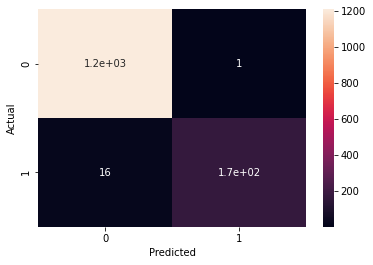

In [112]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {
    "y_Actual": y_test,
    "y_Predicted": y_pred_class,
}

df = pd.DataFrame(data, columns=["y_Actual", "y_Predicted"])
confusion_matrix = pd.crosstab(
    df["y_Actual"], df["y_Predicted"], rownames=["Actual"], colnames=["Predicted"]
)

sn.heatmap(confusion_matrix, annot=True)
plt.show()

In [86]:
# print message text for the false positives (ham incorrectly classified as spam)
X_test[y_test < y_pred_class]

574               Waiting for your call.
3375             Also andros ice etc etc
45      No calls..messages..missed calls
3415             No pic. Please re-send.
1988    No calls..messages..missed calls
Name: message, dtype: object

In [87]:
# print message text for the false negatives (spam incorrectly classified as ham)
X_test[y_test > y_pred_class]

3132    LookAtMe!: Thanks for your purchase of a video...
5       FreeMsg Hey there darling it's been 3 week's n...
3530    Xmas & New Years Eve tickets are now on sale f...
684     Hi I'm sue. I am 20 years old and work as a la...
1875    Would you like to see my XXX pics they are so ...
1893    CALL 09090900040 & LISTEN TO EXTREME DIRTY LIV...
4298    thesmszone.com lets you send free anonymous an...
4949    Hi this is Amy, we will be sending you a free ...
2821    INTERFLORA - It's not too late to order Inter...
2247    Hi ya babe x u 4goten bout me?' scammers getti...
4514    Money i have won wining number 946 wot do i do...
Name: message, dtype: object

In [88]:
# example false negative
X_test[3132]

"LookAtMe!: Thanks for your purchase of a video clip from LookAtMe!, you've been charged 35p. Think you can do better? Why not send a video in a MMSto 32323."

## Part 6: Comparing models

We will compare multinomial Naive Bayes with [logistic regression](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression):

> Logistic regression, despite its name, is a **linear model for classification** rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

![](./figure/logistic_regression.jpg)

In [89]:
# import and instantiate a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [90]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 313 ms, sys: 11 ms, total: 324 ms
Wall time: 99.7 ms


LogisticRegression()

In [91]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

In [92]:
# calculate accuracy
metrics.accuracy_score(y_test, y_pred_class)

0.9877961234745154

## Part 7: Examining a model for further insight

We will examine the our **trained Naive Bayes model** to calculate the approximate **"spamminess" of each token**.

In [93]:
# store the vocabulary of X_train
X_train_tokens = vect.get_feature_names()
len(X_train_tokens)

7456

In [94]:
# examine the first 50 tokens
print(X_train_tokens[0:50])

['00', '000', '008704050406', '0121', '01223585236', '01223585334', '0125698789', '02', '0207', '02072069400', '02073162414', '02085076972', '021', '03', '04', '0430', '05', '050703', '0578', '06', '07', '07008009200', '07090201529', '07090298926', '07123456789', '07732584351', '07734396839', '07742676969', '0776xxxxxxx', '07781482378', '07786200117', '078', '07801543489', '07808', '07808247860', '07808726822', '07815296484', '07821230901', '07880867867', '0789xxxxxxx', '07946746291', '0796xxxxxx', '07973788240', '07xxxxxxxxx', '08', '0800', '08000407165', '08000776320', '08000839402', '08000930705']


In [95]:
# examine the last 50 tokens
print(X_train_tokens[-50:])

['yer', 'yes', 'yest', 'yesterday', 'yet', 'yetunde', 'yijue', 'ym', 'ymca', 'yo', 'yoga', 'yogasana', 'yor', 'yorge', 'you', 'youdoing', 'youi', 'youphone', 'your', 'youre', 'yourjob', 'yours', 'yourself', 'youwanna', 'yowifes', 'yoyyooo', 'yr', 'yrs', 'ything', 'yummmm', 'yummy', 'yun', 'yunny', 'yuo', 'yuou', 'yup', 'zac', 'zaher', 'zealand', 'zebra', 'zed', 'zeros', 'zhong', 'zindgi', 'zoe', 'zoom', 'zouk', 'zyada', 'èn', '〨ud']


In [96]:
# Naive Bayes counts the number of times each token appears in each class
nb.feature_count_

array([[ 0.,  0.,  0., ...,  1.,  1.,  1.],
       [ 5., 23.,  2., ...,  0.,  0.,  0.]])

In [97]:
# rows represent classes, columns represent tokens
nb.feature_count_.shape

(2, 7456)

In [98]:
# number of times each token appears across all HAM messages
ham_token_count = nb.feature_count_[0, :]
ham_token_count

array([0., 0., 0., ..., 1., 1., 1.])

In [99]:
# number of times each token appears across all SPAM messages
spam_token_count = nb.feature_count_[1, :]
spam_token_count

array([ 5., 23.,  2., ...,  0.,  0.,  0.])

In [100]:
# create a DataFrame of tokens with their separate ham and spam counts
tokens = pd.DataFrame(
    {"token": X_train_tokens, "ham": ham_token_count, "spam": spam_token_count}
).set_index("token")
tokens.head()

,ham,spam
token,,
00,0.0,5.0
000,0.0,23.0
008704050406,0.0,2.0
0121,0.0,1.0
01223585236,0.0,1.0


In [101]:
# examine 5 random DataFrame rows
tokens.sample(5, random_state=6)

,ham,spam
token,,
very,64.0,2.0
nasty,1.0,1.0
villa,0.0,1.0
beloved,1.0,0.0
textoperator,0.0,2.0


In [102]:
# Naive Bayes counts the number of observations in each class
nb.class_count_

array([3617.,  562.])

Before we can calculate the "spamminess" of each token, we need to avoid **dividing by zero** and account for the **class imbalance**.

In [104]:
# add 1 to ham and spam counts to avoid producing zero probability
tokens['ham'] = tokens.ham + 1
tokens['spam'] = tokens.spam + 1
tokens.sample(5, random_state=6)

,ham,spam
token,,
very,66.0,4.0
nasty,3.0,3.0
villa,2.0,3.0
beloved,3.0,2.0
textoperator,2.0,4.0


In [105]:
# convert the ham and spam counts into frequencies
tokens['ham'] = tokens.ham / nb.class_count_[0]
tokens['spam'] = tokens.spam / nb.class_count_[1]
tokens.sample(5, random_state=6)

,ham,spam
token,,
very,0.018247,0.007117
nasty,0.000829,0.005338
villa,0.000553,0.005338
beloved,0.000829,0.003559
textoperator,0.000553,0.007117


In [106]:
# calculate the ratio of spam-to-ham for each token
tokens['spam_ratio'] = tokens.spam / tokens.ham
tokens.sample(5, random_state=6)

,ham,spam,spam_ratio
token,,,
very,0.018247,0.007117,0.390057
nasty,0.000829,0.005338,6.435943
villa,0.000553,0.005338,9.653915
beloved,0.000829,0.003559,4.290629
textoperator,0.000553,0.007117,12.871886


In [107]:
# examine the DataFrame sorted by spam_ratio
# note: use sort() instead of sort_values() for pandas 0.16.2 and earlier
tokens.sort_values('spam_ratio', ascending=False)

,ham,spam,spam_ratio
token,,,
claim,0.000553,0.160142,289.617438
prize,0.000553,0.137011,247.783808
150p,0.000553,0.088968,160.898577
www,0.000829,0.131673,158.753262
tone,0.000553,0.087189,157.680605
...,...,...,...
my,0.150677,0.016014,0.106282
she,0.035941,0.003559,0.099015
he,0.047277,0.003559,0.075274


In [108]:
# look up the spam_ratio for a given token
tokens.loc['dating', 'spam_ratio']

45.05160142348754